In [5]:
# Third-party Library Imports
import numpy as np
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import (
    r2_score,
    root_mean_squared_error as root_mean_squared_error
)
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score

# Local Imports
from modules import forecast

import geopandas as gpd

# IPython Magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read SCM & ERA data

In [6]:
scm_era = pd.read_csv("files/ERA/processed/era_scm_final_features_different_MMEs.csv")

# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
unique_scm = [c for c in scm_era.model.unique().tolist() if c != "ERA"] 
mme_models = [m for m in unique_scm if m not in ['CMCC', 'DWD', 'ECCC', 'ECMWF', 'METFR', 'NASA', 'UKMO']]
weather_columns = [c for c in scm_era.columns if ("rain" in c) or ("tmean" in c)]
scm_era = scm_era.assign(yield_loss=scm_era.loc[:, "yield anomaly [%]"].apply(lambda x: 0 if x > 0 else 1))
unique_regions = scm_era.region.unique().tolist()

# from the end-of-season estimation benchmark
regions_with_skill = [
    'Chaco húmedo sur', 'Llanos nordpatagónicos', 'Pampa ondulada sur', 'Pampa semiárida central', 'Pampa subhúmeda norte', 'Pampa subhúmeda sur'
    ]

# preview
scm_era.sample(2)

,year,region,model,init_month,rain_8,rain_9,rain_10,rain_11,tmean_8,tmean_9,tmean_10,tmean_11,yield anomaly [%],harvested area loo [ha],yield_loss
36436,2005,Pampa ondulada norte,MME_2_CMCC_NASA,11,-0.369089,-0.672698,-0.638918,-0.153634,0.854395,0.033876,0.256572,0.104835,7.853191,459503.0,0
27362,1993,Pampa deprimida,MME_2_ECMWF_NASA,10,-0.677247,0.175245,-0.070705,0.208124,-0.804528,-1.279100,-0.773850,-0.961231,5.760981,140957.0,0


In [7]:
#### FOR TESTING ONLY
unique_scm = ['CMCC', 'DWD', 'ECCC', 'ECMWF', 'METFR', 'NASA', 'UKMO']
#mme_models = ["MME_3_ECMWF_METFR_NASA",  "MME_2_ECMWF_NASA"]

### 2. Validate forecast model on regional level

In [8]:
# create empty dataframes to store the annual forecasts and the performance metrics
metrics_by_scm_and_region = pd.DataFrame(0.0, index=pd.MultiIndex.from_product([unique_scm, unique_regions, ["Pearson's", "R2", "RMSE", "ROC"]], names=["SCM", "Region", "metric"]), columns=[6, 7, 8, 9, 10, 11]).sort_index()
annual_forecasts_by_scm_and_region = scm_era[["year", "region", "model", "init_month", "yield anomaly [%]", "yield_loss", "harvested area loo [ha]"]].assign(forecasted=np.nan, yield_loss_forecasted=np.nan)
annual_forecasts_by_scm_and_region = annual_forecasts_by_scm_and_region.loc[annual_forecasts_by_scm_and_region["model"].isin(unique_scm)].reset_index(drop=True).set_index(["region", "model", "init_month", "year"]).sort_index()

for region in unique_regions:
    print(region)
    for month_of_initialization in init_months:
        for scm in unique_scm:
            res, _ = forecast.kfold_cross_validation(data=scm_era, model=scm, init=month_of_initialization, region=region, feature_names=weather_columns)
            res["yield_loss_forecasted"] = res["predicted"].apply(lambda x: 0 if x > 0 else 1)
            
            # store performance
            metrics_by_scm_and_region.loc[(scm, region), month_of_initialization] = [
                np.round(pearsonr(res["yield anomaly [%]"], res["predicted"])[0], 4),
                np.round(r2_score(res["yield anomaly [%]"], res["predicted"]), 4),
                np.round(root_mean_squared_error(res["yield anomaly [%]"], res["predicted"]), 4),
                np.round(roc_auc_score(res["yield_loss"], res["yield_loss_forecasted"] ), 4)
            ]
            # store forecasts
            annual_forecasts_by_scm_and_region.loc[(region, scm, month_of_initialization), "forecasted"] = res["predicted"].values
            annual_forecasts_by_scm_and_region.loc[(region, scm, month_of_initialization), "yield_loss_forecasted"] = res["yield_loss_forecasted"].values


Chaco húmedo sur
Llanos nordpatagónicos
Pampa deprimida
Pampa mesopotámica
Pampa ondulada norte
Pampa ondulada sur
Pampa semiárida central
Pampa semiárida norte
Pampa semiárida sur
Pampa serrana
Pampa subhúmeda norte
Pampa subhúmeda sur


#### Aggregate regional forecasts to national level using estimated harvested area

In [9]:
annual_national_forecasts_by_scm = (
    annual_forecasts_by_scm_and_region.assign(yield_weighted=annual_forecasts_by_scm_and_region["yield anomaly [%]"] * annual_forecasts_by_scm_and_region["harvested area loo [ha]"], 
                            forecasted_weighted=annual_forecasts_by_scm_and_region["forecasted"] * annual_forecasts_by_scm_and_region["harvested area loo [ha]"])
    .groupby(["model", "year", "init_month"])
    .agg({"harvested area loo [ha]": "sum", "yield_weighted": "sum", "forecasted_weighted":"sum"})
    .assign(yield_anomaly=lambda x: x["yield_weighted"] / x["harvested area loo [ha]"],
            forecasted_anomaly=lambda x: x["forecasted_weighted"] / x["harvested area loo [ha]"])
    .reset_index()
    .rename(columns={"yield_anomaly": "yield anomaly [%]", "forecasted_anomaly": "forecasted [%]"})
    [["model", "year", "init_month", "yield anomaly [%]", "forecasted [%]"]]
    .set_index(["model", "init_month", "year"])
    .sort_index()
)

annual_national_forecasts_by_scm["yield_loss_forecasted"] = annual_national_forecasts_by_scm["forecasted [%]"].apply(lambda x: 0 if x > 0 else 1)
annual_national_forecasts_by_scm["yield_loss"] = annual_national_forecasts_by_scm["yield anomaly [%]"].apply(lambda x: 0 if x > 0 else 1)


annual_national_forecasts_by_scm.head(2)

yield anomaly [%]  forecasted [%]  \
model init_month year                                      
CMCC  6          1993          -3.059714       29.980250   
                 1994           2.337391        9.953979   

                       yield_loss_forecasted  yield_loss  
model init_month year                                     
CMCC  6          1993                      0           1  
                 1994                      0           0

#### Obtain national performance metrics

In [10]:
national_metrics_by_scm = pd.DataFrame(0.0, index=pd.MultiIndex.from_product([unique_scm, ["Pearson's", "R2", "RMSE", "ROC"]], names=["SCM", "metric"]), columns=[6, 7, 8, 9, 10, 11]).sort_index()

for model in unique_scm:
    for month in init_months:
        national_forecasts_loop = annual_national_forecasts_by_scm.loc[(model, month)]
        national_metrics_by_scm.loc[(model), month] = [      
            np.round(pearsonr(national_forecasts_loop["yield anomaly [%]"], national_forecasts_loop["forecasted [%]"])[0], 2),
            np.round(r2_score(national_forecasts_loop["yield anomaly [%]"], national_forecasts_loop["forecasted [%]"]), 2),
            np.round(root_mean_squared_error(national_forecasts_loop["yield anomaly [%]"], national_forecasts_loop["forecasted [%]"]), 2),
            np.round(roc_auc_score(national_forecasts_loop["yield_loss"], national_forecasts_loop["yield_loss_forecasted"]), 2)
        ]
national_metrics_by_scm.head(2)      

6     7     8     9     10    11
SCM  metric                                       
CMCC Pearson's  0.05  0.16  0.16  0.18  0.23  0.48
     R2        -1.62 -1.66 -1.26 -0.84 -0.66  0.11

In [22]:
national_metrics_by_scm.loc[national_metrics_by_scm.index.get_level_values(1) == "RMSE"].assign(Mean=national_metrics_by_scm.loc[national_metrics_by_scm.index.get_level_values(1) == "RMSE"].mean(axis=1).round(2)).to_html("individual_scm_rmse.html")

#### 3. Visualize national time series

In [148]:
model_to_plot = "MME_3_ECMWF_METFR_NASA"
#model_to_plot = "MME_2_ECMWF_NASA"

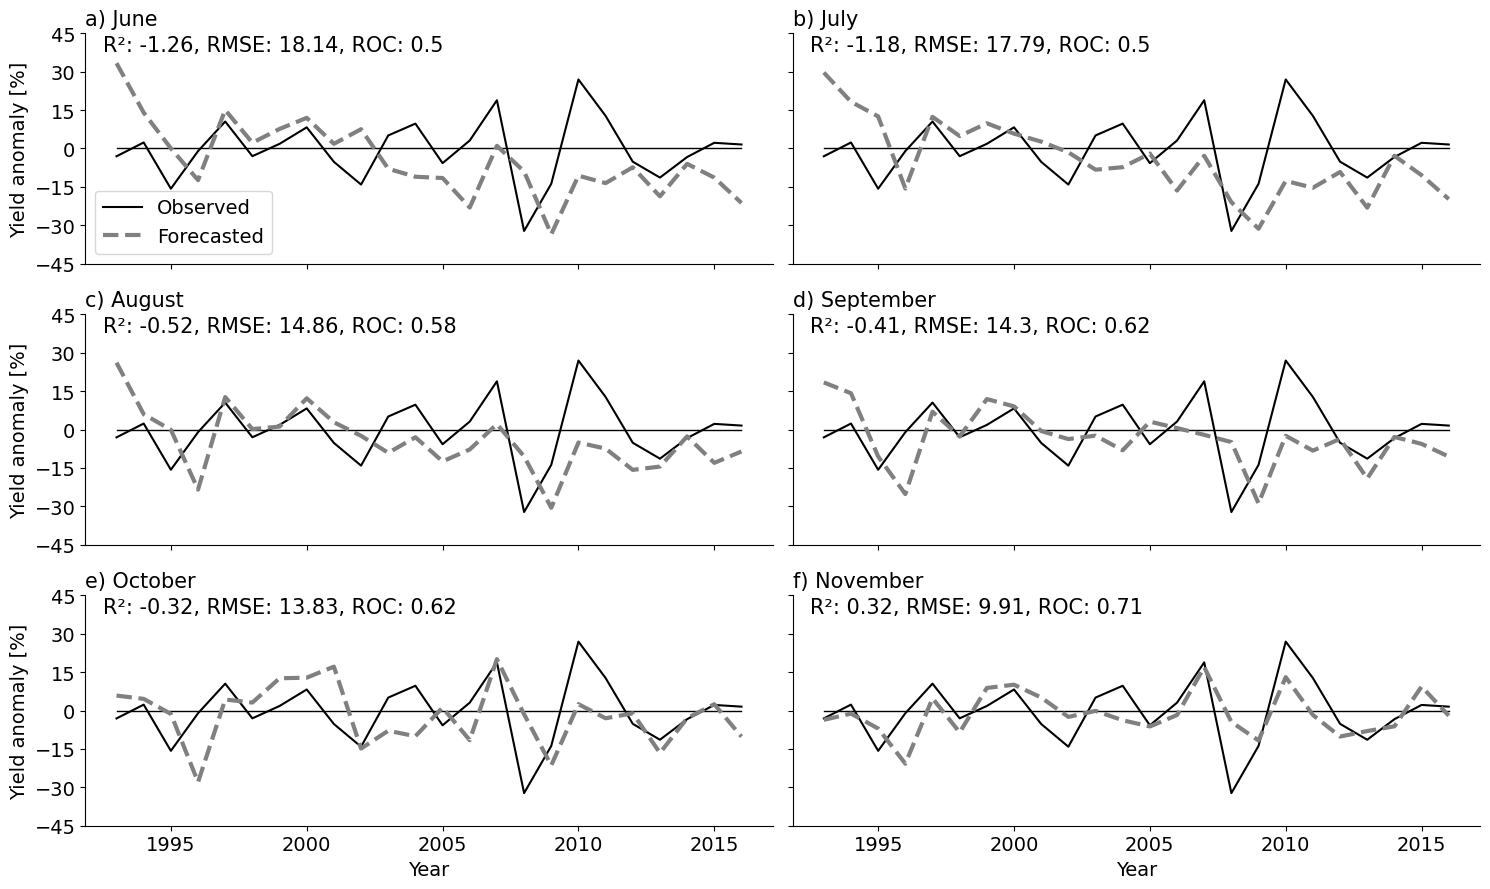

In [149]:
fig, ax = plt.subplots(3, 2, figsize=(15, 9), sharey=True, sharex=True)

ax = ax.ravel()
list_of_counter = ["a)", "b)", "c)", "d)", "e)", "f)"]
month_number_to_name = {6: "June", 7: "July", 8: "August", 9: "September", 10: "October", 11: "November"}

for i, month in enumerate(init_months):
    
    data_to_plot = annual_national_forecasts_by_scm.loc[(model_to_plot, month)]
    year_range = data_to_plot.index.get_level_values("year").unique().tolist()
    
    roc = national_metrics_by_scm.loc[(model_to_plot, "ROC"), month] 
    r2_national = national_metrics_by_scm.loc[(model_to_plot, "R2"), month] 
    rmse_national = national_metrics_by_scm.loc[(model_to_plot, "RMSE"), month] 
    
    ax[i].plot([1993, 2016], [0, 0], color="black", linestyle="-", linewidth=1)
    ax[i].plot(year_range, data_to_plot["yield anomaly [%]"], label="Observed", color="black", linewidth=1.5)
    ax[i].plot(year_range, data_to_plot["forecasted [%]"], label="Forecasted", color="grey", linewidth=3, linestyle="--")
    
    ax[i].set_title("{} {}".format(list_of_counter[i], month_number_to_name[month]), loc="left", fontsize=15)
    if i in [0, 2, 4]:
        ax[i].set_ylabel("Yield anomaly [%]", fontsize=14)
    else:
        ax[i].set_ylabel("")
    if i in [4, 5]:
        ax[i].set_xlabel("Year", fontsize=14)
    ax[i].set_yticks(np.arange(-45, 50, 15))
    ax[i].text(1992.5, 38, "R²: {}, RMSE: {}, ROC: {}".format(r2_national, rmse_national, roc), fontsize=15, color="black")
    ax[i].grid(False)
    ax[i].tick_params(axis='both', which='both', labelsize=14)
    ax[i].legend(fontsize=14)
    if i != 0:
        ax[i].get_legend().remove()
    ax[i].set_facecolor('white')
    ax[i].spines['bottom'].set_color('black')
    ax[i].spines['left'].set_color('black')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Visualize November uncertainty for supplementary materials

Text(0, 0.5, 'Absolute error [%]')

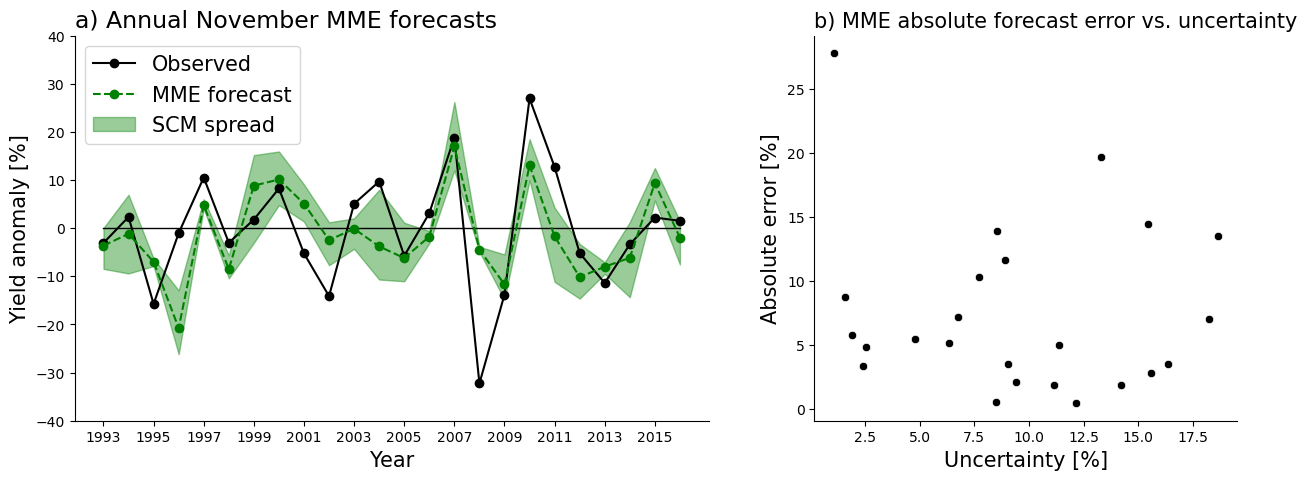

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[3, 2])
axs = axs.ravel()

### Plot a)
national_unique_scms = annual_national_forecasts_by_scm.loc[(annual_national_forecasts_by_scm.index.get_level_values('model').isin(['NASA', 'ECMWF', "METFR"])) & (annual_national_forecasts_by_scm.index.get_level_values('init_month') == 11)]
national_mme = annual_national_forecasts_by_scm.loc[("MME_3_ECMWF_METFR_NASA", 11)]
min_values = national_unique_scms.reset_index().pivot(index="year", columns="model", values="forecasted [%]").min(axis=1).values
max_values = national_unique_scms.reset_index().pivot(index="year", columns="model", values="forecasted [%]").max(axis=1).values
year_range = national_mme.index.get_level_values("year").unique().tolist()

axs[0].plot([min(year_range), max(year_range)], [0, 0], color="black", linestyle="-", linewidth=1)
axs[0].plot(year_range, national_mme["yield anomaly [%]"], label="Observed", color="black", linewidth=1.5, linestyle="-", marker="o")
axs[0].plot(year_range, national_mme["forecasted [%]"], label="MME forecast", color="green", linewidth=1.5, linestyle="--", marker="o")
axs[0].fill_between(year_range, min_values, max_values, color="green", alpha=0.4, label="SCM spread")
axs[0].legend(loc="upper left", fontsize=15)
axs[0].set_title("a) Annual November MME forecasts", fontsize=17, loc="left")
axs[0].set_ylabel("Yield anomaly [%]", fontsize=15)
axs[0].set_xlabel("Year", fontsize=15)
axs[0].set_yticks(list(range(-40, 50, 10)));
axs[0].set_xticks(list(range(1993, 2017, 2)));

# Plot b)
national_mme = national_mme.assign(error = abs(national_mme["yield anomaly [%]"] - national_mme["forecasted [%]"]))
national_mme["spread"] = max_values - min_values

sns.scatterplot(data=national_mme, x="spread", y="error", color="black", ax=axs[1]);
axs[1].set_title("b) MME absolute forecast error vs. uncertainty", fontsize=15, loc="left")
axs[1].set_xlabel("Uncertainty [%]", fontsize=15)
axs[1].set_ylabel("Absolute error [%]", fontsize=15)

### 4. Visualize regional performance

In [133]:
#model_to_plot = "MME_3_ECMWF_METFR_NASA"
model_to_plot = "MME_2_ECMWF_NASA"

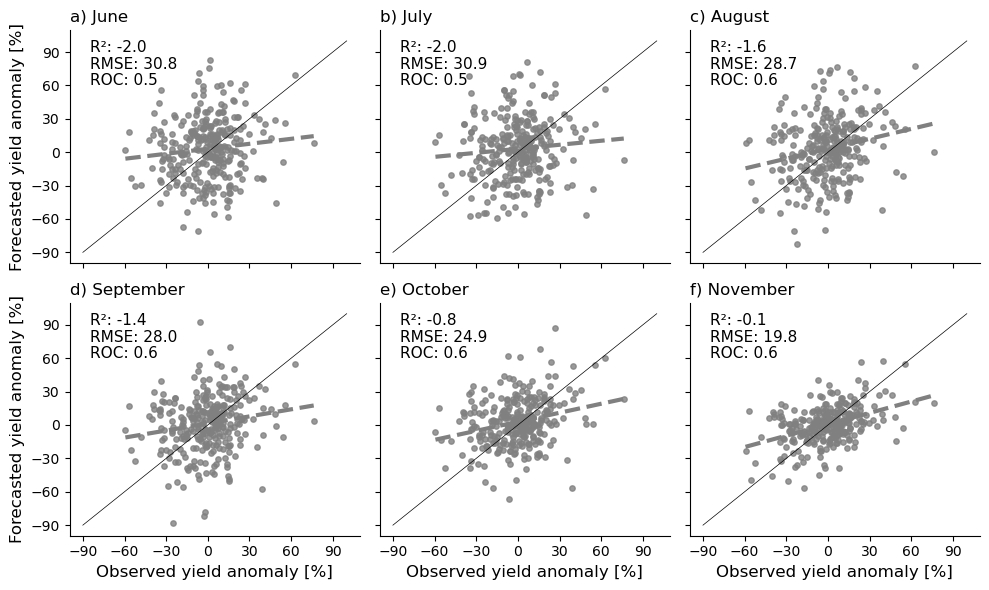

In [134]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharey=True, sharex=True)

list_of_counter = ["a)", "b)", "c)", "d)", "e)", "f)"]
month_number_to_name = {6: "June", 7: "July", 8: "August", 9: "September", 10: "October", 11: "November"}

axs = axs.ravel()
for i, month in enumerate(init_months):
    # Turn off grid lines
    axs[i].grid(False)

    # Set white background
    axs[i].set_facecolor('white')

    # Set black x and y axis
    axs[i].spines['bottom'].set_color('black')
    axs[i].spines['left'].set_color('black')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    
    current_r2 = metrics_by_scm_and_region.loc[model_to_plot, :, "R2"][month].mean().round(1)
    current_rmse = metrics_by_scm_and_region.loc[model_to_plot, :, "RMSE"][month].mean().round(1)
    current_roc = metrics_by_scm_and_region.loc[model_to_plot, :, "ROC"][month].mean().round(1)
    
    data_to_plot = annual_forecasts_by_scm_and_region.loc[:, model_to_plot, month]
    
    sns.regplot(data=data_to_plot, x="yield anomaly [%]", y="forecasted", ci=None, scatter=True, line_kws={"linewidth":3, "linestyle":"--"}, ax=axs[i], color="gray", scatter_kws={"s":15})
    #data_to_plot.plot(x="predictions", y="yield anomaly [%]", kind="scatter", ax=axs[i], color="grey", s=6)
    
    axs[i].text(-85, 90, "R²: {}".format(current_r2), fontsize=11, color="black")
    axs[i].text(-85, 75, "RMSE: {}".format(current_rmse), fontsize=11, color="black")
    axs[i].text(-85, 60, "ROC: {}".format(current_roc), fontsize=11, color="black")
    axs[i].plot([-90, 100], [-90, 100], color="black", linestyle="-", linewidth=.5)
    axs[i].set_xticks(np.arange(-90, 110, 30))
    axs[i].set_yticks(np.arange(-90, 110, 30))
    axs[i].set_title("{} {}".format(list_of_counter[i], month_number_to_name[month]), loc="left", fontsize=12)
    if i in [0, 3]:
        axs[i].set_ylabel("Forecasted yield anomaly [%]", fontsize=12)
    else:
        axs[i].set_ylabel("")
        
    if i in [0, 1, 2]:
        axs[i].set_xlabel("")
    else:
        axs[i].set_xlabel("Observed yield anomaly [%]", fontsize=12)

plt.tight_layout()
#plt.grid(b=None)
plt.show()

### Spatial regional analysis for supplementary materials

In [138]:
model_to_plot = "MME_3_ECMWF_METFR_NASA"
#model_to_plot = "MME_2_ECMWF_NASA"

In [139]:
regions_shape = gpd.read_file("files/shapefiles/study_region_v2.shp")

results_r2_regions = metrics_by_scm_and_region.loc[model_to_plot,:, "R2"].reset_index().merge(regions_shape[["region", "geometry"]], left_on="Region", right_on="region", how="left")[["region", "geometry"] + init_months]
results_r2_regions = gpd.GeoDataFrame(results_r2_regions, geometry="geometry", crs=regions_shape.crs)
#results_r2_regions[init_months] = results_r2_regions[init_months].mask(results_r2_regions[init_months] < 0, np.nan)

results_rmse_regions = metrics_by_scm_and_region.loc[model_to_plot,:, "RMSE"].reset_index().merge(regions_shape[["region", "geometry"]], left_on="Region", right_on="region", how="left")[["region", "geometry"] + init_months]
results_rmse_regions = gpd.GeoDataFrame(results_rmse_regions, geometry="geometry", crs=regions_shape.crs)

results_roc_regions = metrics_by_scm_and_region.loc[model_to_plot,:, "ROC"].reset_index().merge(regions_shape[["region", "geometry"]], left_on="Region", right_on="region", how="left")[["region", "geometry"] + init_months]
results_roc_regions = gpd.GeoDataFrame(results_roc_regions, geometry="geometry", crs=regions_shape.crs)
#results_roc_regions[init_months] = results_roc_regions[init_months].mask(results_roc_regions[init_months] <= 0.6, np.nan)

In [147]:
results_r2_regions.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

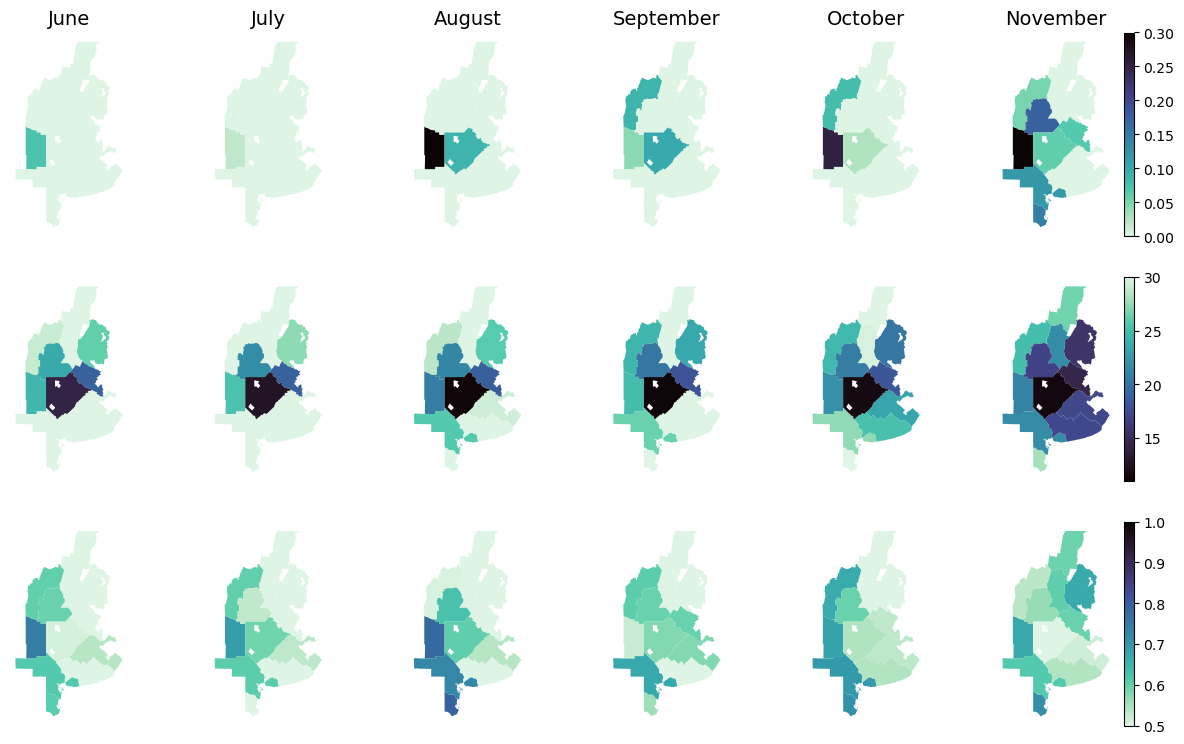

In [140]:
fig, axs = plt.subplots(3, 6, figsize=(15, 9), sharey=True, sharex=True)
axs = axs.ravel()

#labels = ["a) Regional R\u00b2", "b) Regional RMSE [%]", "c) Regional ROC", "d) National R\u00b2", "e) National RMSE [%]", "f) National ROC"]
months_as_names = ["June", "July", "August", "September", "October", "November"]
metric_to_color = {"r2": "mako_r", "rmse": "mako", "roc": "mako_r"}
metric_to_vmin = {"r2": 0, "rmse":8, "roc": 0.5}
metric_to_vmax = {"r2": 0.4, "rmse":20, "roc": 1}

for i, month in enumerate(init_months):
    if i not in [5, 11, 17]:
        legend_ = False
    elif i in [5, 11, 17]:
        legend_ = True
    results_r2_regions.plot(column=month, ax=axs[i], legend=legend_, vmin=0, vmax=0.3, legend_kwds={"orientation": "vertical"}, missing_kwds= dict(color = "lightgrey",), cmap="mako_r")
    results_rmse_regions.plot(column=month, ax=axs[i+6], legend=legend_, vmin=11, vmax=30, legend_kwds={"orientation": "vertical"}, missing_kwds= dict(color = "lightgrey",), cmap="mako")
    results_roc_regions.plot(column=month, ax=axs[i+12], legend=legend_, vmin=0.5, vmax=1, legend_kwds={"orientation": "vertical"}, missing_kwds= dict(color = "lightgrey",), cmap="mako_r")
    axs[i].set_title("{}".format(months_as_names[i]), fontsize=14)
    
    if i == 0:
        axs[i].set_ylabel("Regional R²", fontsize=12)
        axs[i+6].set_ylabel("Regional RMSE [%]", fontsize=12)
        axs[i+12].set_ylabel("Regional ROC", fontsize=12)
    else:
        axs[i].set_ylabel("")
        axs[i+6].set_ylabel("")
        axs[i+12].set_ylabel("")
    
    axs[i].axis("off")
    axs[i+6].axis("off")
    axs[i+12].axis("off")

#plt.title("R² for MME by region and month of initialization", loc="center")
plt.show()
    

In [146]:
metrics_by_scm_and_region.loc[model_to_plot, :, ["R2", "RMSE", "ROC"]].round(2).to_html("metrics_by_scm_and_region.html")